In [26]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [84]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>', ' ', s)           # quitar HTML
    s = re.sub(r'http\S+|www\.\S+', ' <URL> ', s)  # URLs -> token
    s = re.sub(r'\d{2,}', ' <NUM> ', s)     # números largos -> token
    s = re.sub(r'[^a-zA-Z0-9<> ]', ' ', s)  # quitar puntuación (simple)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

## get dataset

In [85]:
path_data = "dataset/spam.csv"
test_data = "dataset/spam_or_not_spam.csv"

In [86]:
df = pd.read_csv(path_data)
dt = pd.read_csv(test_data)

In [87]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [88]:
cols = dt.columns.str.lower()
if 'email' in cols:
    dt = dt.rename(columns={dt.columns[cols.tolist().index('email')]: 'message',})
else:
    # si no, inspecciona manualmente (muestra primeros 5 columnas)
    print("Revisa los nombres de columnas. Aquí un ejemplo:")
    display(df.head())

In [89]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [90]:
for label in df['Category'].unique():
    textos = df[df['Category'] == label]['Message'].astype(str)
    cv = CountVectorizer(stop_words='english', min_df=2)
    Xc = cv.fit_transform(textos)
    words = np.array(cv.get_feature_names_out())
    sums = Xc.toarray().sum(axis=0)
    top_idx = sums.argsort()[::-1][:20]
    print(f"Top palabras para '{label}':")
    print(words[top_idx])
    print()

Top palabras para 'ham':
['gt' 'lt' 'just' 'ok' 'll' 'ur' 'know' 'good' 'like' 'got' 'come' 'day'
 'love' 'time' 'going' 'want' 'home' 'lor' 'need' 'don']

Top palabras para 'spam':
['free' 'txt' 'ur' 'mobile' 'text' 'stop' 'claim' 'reply' 'www' 'prize'
 'just' 'cash' 'uk' 'won' '150p' 'send' 'new' 'nokia' 'win' 'urgent']



## transforming data

In [91]:
# ejemplo robusto: detectar columnas probables

cols = df.columns.str.lower()
if 'message' in cols and 'category' in cols:
    df = df.rename(columns={df.columns[cols.tolist().index('message')]: 'message',
                            df.columns[cols.tolist().index('category')]: 'label'})
else:
    # si no, inspecciona manualmente (muestra primeros 5 columnas)
    print("Revisa los nombres de columnas. Aquí un ejemplo:")
    display(df.head())

In [92]:
df['msg_len'] = df['message'].str.len()
print(df.groupby('label')['msg_len'].describe())

        count       mean        std  min    25%    50%    75%    max
label                                                               
ham    4825.0   71.44829  58.434864  2.0   33.0   52.0   93.0  910.0
spam    747.0  137.98929  29.980287  7.0  132.0  149.0  157.0  223.0


In [93]:
df['message_clean'] = df['message'].apply(clean_text)

In [94]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [95]:
test_x = dt['message'].apply(clean_text)
test_y = dt["label"]

In [96]:
X = df['message_clean']
y = df['label']

# stratify para mantener proporciones ham/spam
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## MultinomialNB train

In [73]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ('clf', MultinomialNB(alpha=0.1))
])

In [180]:
param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__min_df': [1,2,3],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0]
}

gs = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
best = gs.best_estimator_
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'clf__alpha': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       1.00      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [181]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Confusion matrix:
 [[966   0]
 [ 11 138]]


In [184]:
y_pred = best.predict(test_x)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2500
           1       0.52      0.13      0.21       500

    accuracy                           0.83      3000
   macro avg       0.68      0.55      0.56      3000
weighted avg       0.79      0.83      0.79      3000



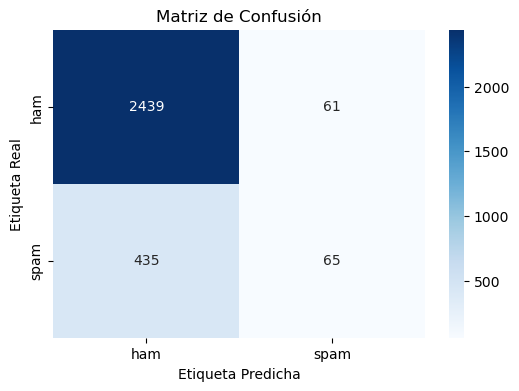

In [190]:
cm = confusion_matrix(test_y, y_pred)
labels = ['ham', 'spam']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

In [208]:
test_y

0       0
1       0
2       0
3       0
4       0
       ..
2995    1
2996    1
2997    1
2998    1
2999    1
Name: label, Length: 3000, dtype: int64

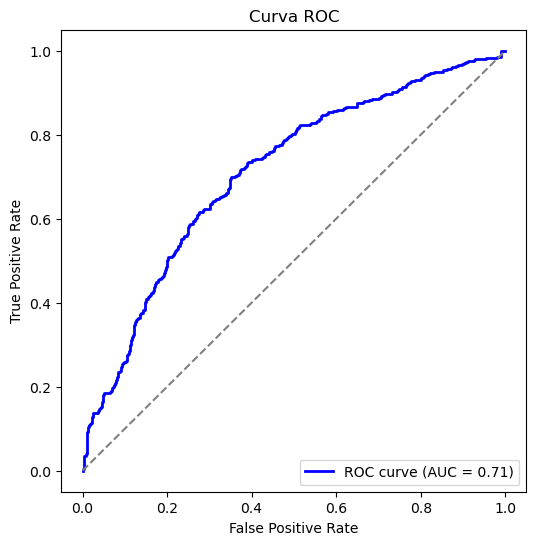

In [209]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#
y_prob = best.predict_proba(test_x)[:, 1]  

# Calcular puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(test_y, y_prob)

# Calcular AUC (Area Under Curve)
roc_auc = roc_auc_score(test_y, y_prob)

# Graficar
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [65]:
best.named_steps

{'tfidf': TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2)),
 'clf': MultinomialNB(alpha=0.1)}

## Suport Vector Machine

In [191]:
pipeline_SVM = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(max_iter=5000))
])

In [192]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__stop_words': [None, 'english'],
    'clf__C': [0.01, 0.1, 1, 10]
}


In [193]:
gs = GridSearchCV(pipeline_SVM, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

print("Mejores parámetros:", gs.best_params_)
print("Mejor score:", gs.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Mejores parámetros: {'clf__C': 10, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Mejor score: 0.9891000114179773
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       0.99      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [195]:
y_pred = gs.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.77      2500
           1       0.28      0.61      0.38       500

    accuracy                           0.67      3000
   macro avg       0.59      0.65      0.58      3000
weighted avg       0.79      0.67      0.71      3000



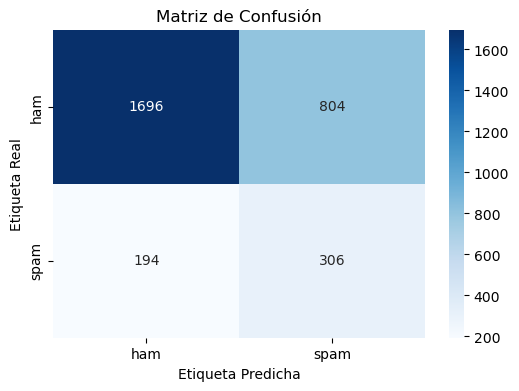

In [196]:
cm = confusion_matrix(test_y, y_pred)
labels = ['ham', 'spam']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

In [197]:
y_pred = gs.predict(test_x)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.77      2500
           1       0.28      0.61      0.38       500

    accuracy                           0.67      3000
   macro avg       0.59      0.65      0.58      3000
weighted avg       0.79      0.67      0.71      3000



# Random Forest 

In [97]:
pipeline_fst = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [98]:
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__stop_words': [None, 'english'],
    'clf__n_estimators': [100, 300, 500],
    'clf__max_depth': [None, 20, 50],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__class_weight': [None, 'balanced']
}

In [99]:
gs = RandomizedSearchCV(
    pipeline_fst,
    param_distributions=param_grid,
    n_iter=20,             # probar solo 20 combinaciones
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,             # usa todos los cores
    verbose=1,
    random_state=42
)
gs.fit(X_train, y_train)

print("Mejores parámetros:", gs.best_params_)
print("Mejor score:", gs.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'tfidf__stop_words': None, 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 3, 'tfidf__max_df': 0.9, 'clf__n_estimators': 300, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 5, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__class_weight': 'balanced'}
Mejor score: 0.9853921760020707


In [100]:
y_pred = gs.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2500
           1       0.51      0.39      0.45       500

    accuracy                           0.84      3000
   macro avg       0.70      0.66      0.67      3000
weighted avg       0.82      0.84      0.83      3000



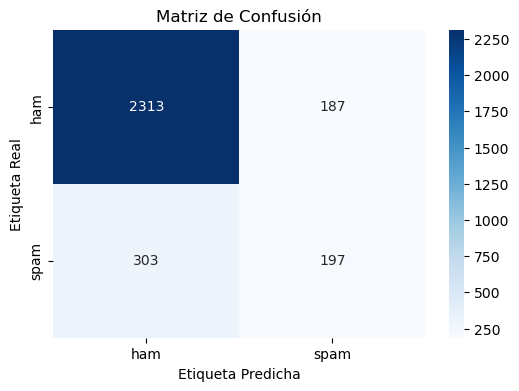

In [101]:
cm = confusion_matrix(test_y, y_pred)
labels = ['ham', 'spam']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()

In [102]:
y_pred = gs.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2500
           1       0.51      0.39      0.45       500

    accuracy                           0.84      3000
   macro avg       0.70      0.66      0.67      3000
weighted avg       0.82      0.84      0.83      3000

